### Multiclass Support Vector Machines
In this exercise you will:
- implement a fully-vectorized loss function for the mulri-class SVM
- implement the fully-vectorized expression for its analytic gradient
- check your implementation using numerical gradient
- use a validation set to tune the learning rate and regularization strength
- optimize the loss function with SGD
- visualize the final learned parameters

In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

### CIFAR-10 Data Loading and Preprocessing
Open up a terminal window and navigate to the datasets folder inside the hw3 folder. Run the get_datasets.sh script. On my Mac, I just type in ./get_datasets.sh at the shell prompt. A new folder called cifar_10_batches_py will be created and it will contain 50000 labeled images for training and  10000 labeled images for testing. The function further partitions the  50000 training images into a train set and a validation set for selection of hyperparameters. We have provided a function to read this data in **data_utils.py**. Each image is a  32×32
array of RGB triples. It is preprocessed by subtracting the mean image from all images. We flatten each image into a 1-dimensional array of size 3072 (i.e.,  32×32×3). Then a 1 is appended to the front of that vector to handle the intercept term. So the training set is a numpy matrix of size  49000×3073, the validation set is a matrix of size  1000×3073 and the set-aside test set is of size  10000×3073. We also have a random sample of 500 images from the training data to serve as a development set or dev set to test our gradient and loss function implementations.

In [2]:
import data_utils

# Get the CIFAR-10 data broken up into train, validation and test sets

X_train, y_train, X_val, y_val, X_dev, y_dev, X_test, y_test = data_utils.get_CIFAR10_data()

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)
Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (10000, 3072)
dev data shape:  (500, 3072)
Training data shape with bias term:  (49000, 3073)
Validation data shape with bias term:  (1000, 3073)
Test data shape with bias term:  (10000, 3073)
Devset data shape with bias term:  (500, 3073)


### SVM Classifier
Your code for this section will all be written inside **linear_svm.py**.
You will need to write the function **naive_loss_svm** which uses for loops to evaluate the multiclass SVM loss function.

In [3]:
# Evaluate the naive implementation of the loss we provided for you:
from linear_svm import svm_loss_naive
import time

# generate a random SVM coefficient matrix of small numbers
theta = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(theta, X_train, y_train, 0.00001)
print 'loss: %f' % (loss, )

loss: 9.093383


The grad returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function **svm_loss_naive**. You will find it helpful to interleave your new code inside the existing function.
To check that you have correctly implemented the gradient, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you.

In [4]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at theta.
loss, grad = svm_loss_naive(theta, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from gradient_check import grad_check_sparse
f = lambda th: svm_loss_naive(th, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, theta, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(theta, X_dev, y_dev, 1e2)
f = lambda w: svm_loss_naive(theta, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, theta, grad)

numerical: -5.582931 analytic: -5.582931, relative error: 5.411019e-11
numerical: -42.001637 analytic: -42.001637, relative error: 6.440988e-12
numerical: -12.381082 analytic: -12.381082, relative error: 2.176306e-11
numerical: 24.492907 analytic: 24.492907, relative error: 2.425567e-11
numerical: 11.191652 analytic: 11.191652, relative error: 2.596423e-11
numerical: 36.168858 analytic: 36.168858, relative error: 1.278114e-12
numerical: 11.957792 analytic: 11.957792, relative error: 4.181679e-11
numerical: -26.126360 analytic: -26.126360, relative error: 9.299874e-12
numerical: 7.787159 analytic: 7.787159, relative error: 1.901840e-12
numerical: -7.209536 analytic: -7.209536, relative error: 5.298787e-11
numerical: -10.569374 analytic: -10.569374, relative error: 1.554942e-11
numerical: 27.697327 analytic: 27.697327, relative error: 3.668884e-12
numerical: 8.904226 analytic: 8.904226, relative error: 1.437987e-11
numerical: 36.016982 analytic: 36.016982, relative error: 7.702795e-13
nu

In [5]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(theta, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(theta, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# The losses should match but your vectorized implementation should be much faster.
print 'difference: %f' % (loss_naive - loss_vectorized)

Naive loss: 9.194808e+00 computed in 0.333960s
Vectorized loss: 9.194808e+00 computed in 0.035477s
difference: -0.000000


### Vectorized version of the gradient computation
Complete the implementation of svm_loss_vectorized, and compute the gradient
of the loss function in a vectorized way.



In [6]:
# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(theta, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Naive loss and gradient: computed in %fs' % (toc - tic)

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(theta, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Vectorized loss and gradient: computed in %fs' % (toc - tic)

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'difference: %f' % difference

Naive loss and gradient: computed in 0.331430s
Vectorized loss and gradient: computed in 0.021538s
difference: 0.000000


In [7]:
# In the file linear_classifier.py, we have implemented SGD in the function
# LinearClassifier.train() and you can run it with the code below.
from linear_classifier import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-6, reg=5e4, 
                      num_iters=1500, verbose=True)
toc = time.time()
print 'That took %fs' % (toc - tic)

iteration 0 / 1500: loss 27.840815
iteration 100 / 1500: loss 10.717758
iteration 200 / 1500: loss 9.337450
iteration 300 / 1500: loss 8.789032
iteration 400 / 1500: loss 9.208571
iteration 500 / 1500: loss 7.809554
iteration 600 / 1500: loss 8.016668
iteration 700 / 1500: loss 7.675779
iteration 800 / 1500: loss 8.439846
iteration 900 / 1500: loss 6.977067
iteration 1000 / 1500: loss 7.108064
iteration 1100 / 1500: loss 7.857100
iteration 1200 / 1500: loss 7.377381
iteration 1300 / 1500: loss 6.970924
iteration 1400 / 1500: loss 6.928093
That took 17.860793s


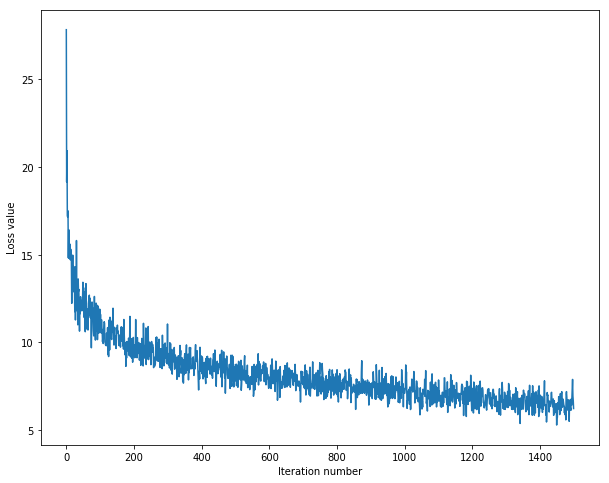

In [8]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### Prediction with an SVM
Compute $\theta^T  x$ for a new example $x$ and pick the class with the highest score.

In [9]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print 'training accuracy: %f' % (np.mean(y_train == y_train_pred), )
y_val_pred = svm.predict(X_val)
print 'validation accuracy: %f' % (np.mean(y_val == y_val_pred), )

training accuracy: 0.375837
validation accuracy: 0.365000


In [10]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.38 or higher on the validation set.

learning_rates = [1e-8, 5e-8, 1e-7, 5e-7, 1e-6]
regularization_strengths = [1e4, 5e4, 1e5, 5e5]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
tic = time.time()
for rate in learning_rates:
    for reg in regularization_strengths:
        print "training with learning rate %e and regularization strength %e" %(rate, reg)
        svm =  LinearSVM()
        loss_history =  svm.train(X_train, y_train, learning_rate=rate, reg=reg, num_iters=5000, verbose=False)
        y_train_pred = svm.predict(X_train)
        train_accuracy = np.mean(y_train_pred == y_train)
        y_val_pred = svm.predict(X_val)
        val_accuracy = np.mean(y_val_pred == y_val)
        results[(rate, reg)] = [train_accuracy, val_accuracy]
        if val_accuracy > best_val:
            best_svm = svm
            best_val = val_accuracy
toc = time.time()


training with learning rate 1.000000e-08 and regularization strength 1.000000e+04
training with learning rate 1.000000e-08 and regularization strength 5.000000e+04
training with learning rate 1.000000e-08 and regularization strength 1.000000e+05
training with learning rate 1.000000e-08 and regularization strength 5.000000e+05
training with learning rate 5.000000e-08 and regularization strength 1.000000e+04
training with learning rate 5.000000e-08 and regularization strength 5.000000e+04
training with learning rate 5.000000e-08 and regularization strength 1.000000e+05
training with learning rate 5.000000e-08 and regularization strength 5.000000e+05
training with learning rate 1.000000e-07 and regularization strength 1.000000e+04
training with learning rate 1.000000e-07 and regularization strength 5.000000e+04
training with learning rate 1.000000e-07 and regularization strength 1.000000e+05
training with learning rate 1.000000e-07 and regularization strength 5.000000e+05
training with le

In [11]:
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
print 'time for training is  %fs' % (toc - tic)
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

time for training is  605.319301s
lr 1.000000e-08 reg 1.000000e+04 train accuracy: 0.261714 val accuracy: 0.266000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.270816 val accuracy: 0.280000
lr 1.000000e-08 reg 1.000000e+05 train accuracy: 0.269082 val accuracy: 0.287000
lr 1.000000e-08 reg 5.000000e+05 train accuracy: 0.269143 val accuracy: 0.269000
lr 5.000000e-08 reg 1.000000e+04 train accuracy: 0.324204 val accuracy: 0.328000
lr 5.000000e-08 reg 5.000000e+04 train accuracy: 0.325429 val accuracy: 0.338000
lr 5.000000e-08 reg 1.000000e+05 train accuracy: 0.329041 val accuracy: 0.326000
lr 5.000000e-08 reg 5.000000e+05 train accuracy: 0.353408 val accuracy: 0.347000
lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.348735 val accuracy: 0.345000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.353959 val accuracy: 0.362000
lr 1.000000e-07 reg 1.000000e+05 train accuracy: 0.361816 val accuracy: 0.356000
lr 1.000000e-07 reg 5.000000e+05 train accuracy: 0.401224 val accuracy: 0.3

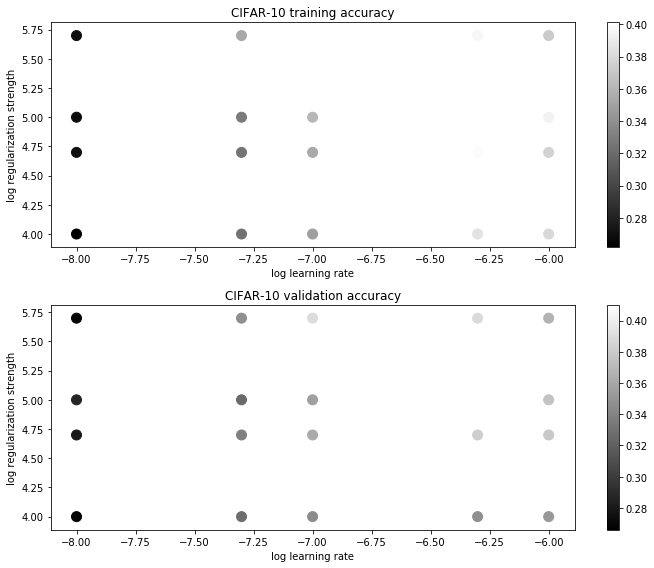

In [12]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.tight_layout()
plt.show()

In [13]:
# Evaluate the best svm on test set
from sklearn.metrics import confusion_matrix
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'linear SVM on raw pixels final test set accuracy: %f' % test_accuracy
X = confusion_matrix(y_test,y_test_pred).astype('float')
print "confusion matrix:"
print X

linear SVM on raw pixels final test set accuracy: 0.371300
confusion matrix:
[[372.  47.  40. 132.  17.  26.  27.  50. 207.  82.]
 [ 52. 422.  26.  56.  22.  68.  45.  37.  95. 177.]
 [ 71.  74. 211. 123. 104.  92. 177.  65.  62.  21.]
 [ 26.  77.  98. 223.  60. 242. 146.  33.  40.  55.]
 [ 38.  50. 122.  75. 260.  83. 211.  91.  43.  27.]
 [ 32.  51.  76. 168.  80. 348. 104.  71.  43.  27.]
 [  6.  39.  49. 155.  77. 100. 505.  28.  21.  20.]
 [ 42.  49.  65.  91.  98. 106.  54. 362.  39.  94.]
 [146.  56.  14.  38.   7.  58.  13.  18. 535. 115.]
 [ 91. 144.  12.  45.  16.  33.  57.  43.  84. 475.]]


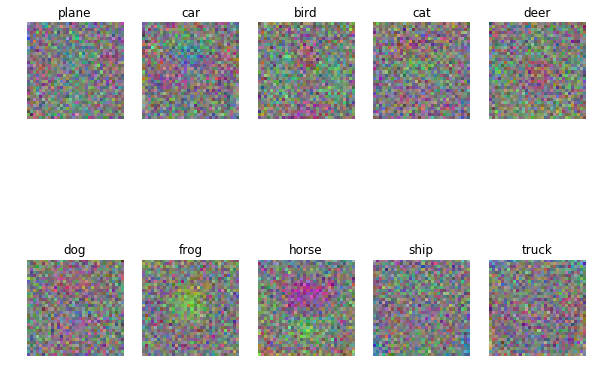

In [14]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.

theta = best_svm.theta[:-1,:] # strip out the bias
theta = theta.reshape(32, 32, 3, 10)
theta_min, theta_max = np.min(theta), np.max(theta)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
    
  # Rescale the weights to be between 0 and 255
  thetaimg = 255.0 * (theta[:, :, :, i].squeeze() - theta_min) / (theta_max - theta_min)
  plt.imshow(thetaimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])

plt.savefig('p4_visualization.pdf')